### Intro Project and import neccessary modules

In [1]:
from torchinfo import summary
import warnings
import yaml
import os
import sys

from src.data import IWSLT2017DataLoader, Multi30kDataLoader
from utils.logger import get_logger
from src.transformer import Seq2SeqTransformer
from src.trainer import Trainer, EarlyStopper
from utils.config import SharedConfig, DataLoaderConfig, TransformerConfig, TrainerConfig
from src.processor import Processor
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Section Load Dataloader

In [2]:
path_to_config = './configs/multi30k-small.yaml'
run_id = 'multi30k-small'
device = 'cuda'

logger = get_logger("Main")
      
if os.path.exists(f'./models/{run_id}/metrics'):
      logger.error('Run ID already exists!')
      sys.exit(1)
else:
      os.makedirs(f'./models/{run_id}/metrics')
      
with open(path_to_config) as stream:
      config = yaml.safe_load(stream)

shared_conf = SharedConfig(run_id=run_id)
dl_conf = DataLoaderConfig(**config['dataloader'])

if dl_conf.dataset == "iwslt2017":
      dataloader = IWSLT2017DataLoader.new_instance(dl_conf, shared_conf)
else:
      # backtranslate False because it is very time consuming
      dataloader = Multi30kDataLoader.new_instance(dl_conf, shared_conf, back_translate=False)
            
train_dataloader = dataloader.train_dataloader
test_dataloader = dataloader.test_dataloader
val_dataloader = dataloader.val_dataloader
tokenizer = dataloader.tokenizer
val_dataset = dataloader.val_dataset

2024-06-14 20:24:31,488 | DataLoader | INFO : Datasets have benn loaded.


2024-06-14 20:26:55,517 | DataLoader | INFO : Dataloaders have been built.


### Section Load Model and Processor

In [5]:
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE = tokenizer.get_vocab_size(), tokenizer.get_vocab_size()

model_conf = TransformerConfig(
      **config['transformer'], 
      src_vocab_size=SRC_VOCAB_SIZE, 
      tgt_vocab_size=TGT_VOCAB_SIZE
)

transformer = Seq2SeqTransformer(model_conf)
translator = Processor.from_instance(transformer, tokenizer, device)

trainer_conf = TrainerConfig(
      **config['trainer'],
      device=device, 
      batch_size=dl_conf.batch_size
)

print(shared_conf.model_dump())
print(dl_conf.model_dump())
print(model_conf.model_dump())
print(trainer_conf.model_dump())

summary(transformer, [(256, dl_conf.batch_size), (256, dl_conf.batch_size), 
                      (256, 256), (256, 256), 
                      (dl_conf.batch_size, 256), (dl_conf.batch_size, 256)], depth=3)

{'special_symbols': ['<unk>', '<bos>', '<eos>', '<pad>'], 'src_language': 'en', 'tgt_language': 'de', 'run_id': 'multi30k-small'}
{'dataset': 'multi30k', 'batch_size': 128, 'num_workers': 4, 'pin_memory': True, 'drop_last': False, 'shuffle': True}
{'num_encoder_layers': 3, 'num_decoder_layers': 3, 'emb_size': 256, 'nhead': 4, 'src_vocab_size': 1640, 'tgt_vocab_size': 1640, 'dim_feedforward': 1024, 'dropout': 0.14}
{'learning_rate': 0.0005, 'num_epochs': 45, 'batch_size': 128, 'tgt_batch_size': 256, 'warmup_steps': 1500}


Layer (type:depth-idx)                             Output Shape              Param #
Seq2SeqTransformer                                 [256, 128, 1640]          --
├─TokenEmbedding: 1-1                              [256, 128, 256]           --
│    └─Embedding: 2-1                              [256, 128, 256]           419,840
├─PositionalEncoding: 1-2                          [256, 128, 256]           --
│    └─Dropout: 2-2                                [256, 128, 256]           --
├─TokenEmbedding: 1-3                              [256, 128, 256]           --
│    └─Embedding: 2-3                              [256, 128, 256]           419,840
├─PositionalEncoding: 1-4                          [256, 128, 256]           --
│    └─Dropout: 2-4                                [256, 128, 256]           --
├─Transformer: 1-5                                 [256, 128, 256]           --
│    └─TransformerEncoder: 2-5                     [256, 128, 256]           --
│    │    └─ModuleList: 3

### Section Train model

In [6]:
early_stopper = EarlyStopper(warmup=17, patience=7, min_delta=0)

trainer = Trainer.new_instance(transformer, translator, train_dataloader, test_dataloader, val_dataloader, 
                               tokenizer, early_stopper, trainer_conf, device, run_id)

trainer.train()

2024-06-14 20:28:12,128 | Trainer | INFO : epoch 1 avg_training_loss: 6.668 (9.987s)
2024-06-14 20:28:12,541 | Trainer | INFO : epoch 1 avg_test_loss: 6.035 (0.412s)
2024-06-14 20:28:22,683 | Trainer | INFO : epoch 2 avg_training_loss: 5.525 (9.839s)
2024-06-14 20:28:23,150 | Trainer | INFO : epoch 2 avg_test_loss: 4.819 (0.466s)
2024-06-14 20:28:33,267 | Trainer | INFO : epoch 3 avg_training_loss: 4.463 (9.861s)
2024-06-14 20:28:33,710 | Trainer | INFO : epoch 3 avg_test_loss: 3.859 (0.442s)
2024-06-14 20:28:43,963 | Trainer | INFO : epoch 4 avg_training_loss: 3.687 (10.008s)
2024-06-14 20:28:44,384 | Trainer | INFO : epoch 4 avg_test_loss: 3.293 (0.42s)
2024-06-14 20:28:54,566 | Trainer | INFO : epoch 5 avg_training_loss: 3.207 (9.932s)
2024-06-14 20:28:55,029 | Trainer | INFO : epoch 5 avg_test_loss: 2.9 (0.462s)
2024-06-14 20:29:05,138 | Trainer | INFO : epoch 6 avg_training_loss: 2.851 (9.861s)
2024-06-14 20:29:05,548 | Trainer | INFO : epoch 6 avg_test_loss: 2.574 (0.41s)
2024-06

### Section Evaluate

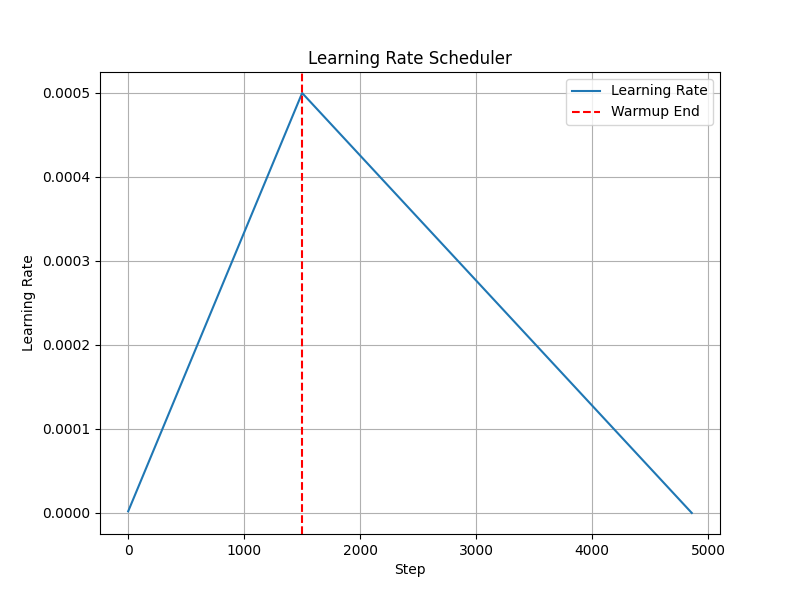

In [7]:
from IPython.display import Image
Image(filename=f'./models/{run_id}/metrics/learning_rate.png')

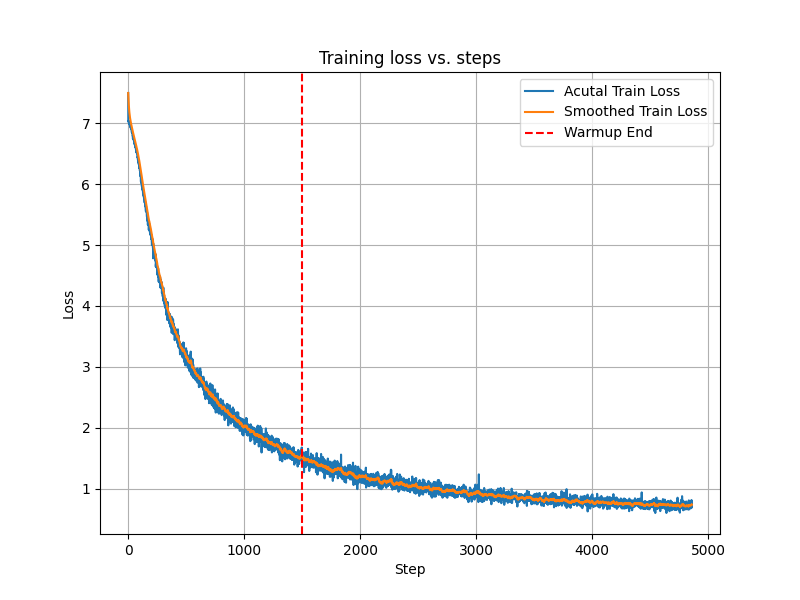

In [8]:
Image(filename=f'./models/{run_id}/metrics/train_loss.png')

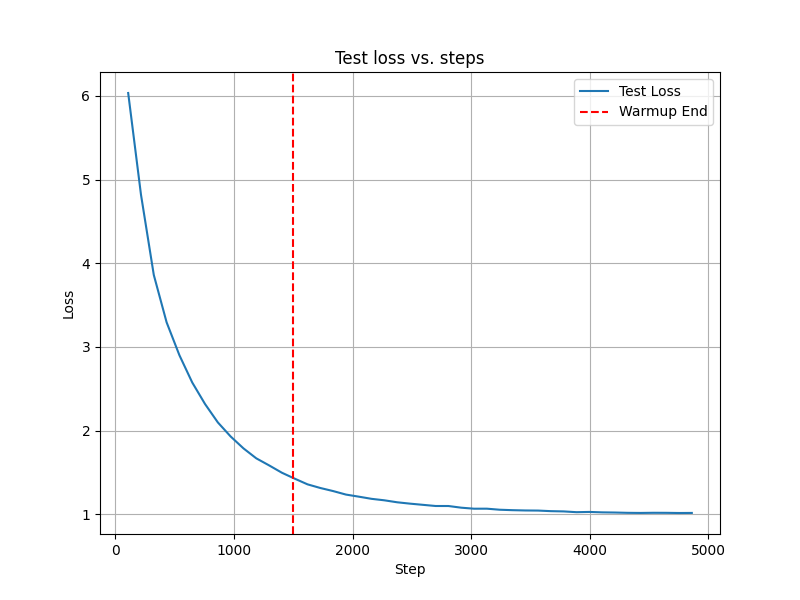

In [9]:
Image(filename=f'./models/{run_id}/metrics/test_loss.png')

In [ ]:
# Only execute if no training was executed yet.
shared_conf = SharedConfig()
dl_conf = DataLoaderConfig()

dataloader = IWSLT2017DataLoader(dl_conf, shared_conf)
            
val_dataset = dataloader.val_dataset

### Prepare translator, metrics and dataset

In [10]:
from evaluate import load as load_metric
import torch
# If one want to evaluate another model that was not trained before through this notebook - 
# specify here the path to the model checkpoint and tokenizer:
# path_to_checkpoint = ""
# path_to_tokenizer = ""
# Don't forget to comment the paths below

model_dir = f"./models/{run_id}"
path_to_tokenizer = f"{model_dir}/tokenizer.json"

if os.path.isfile(f"{model_dir}/best_checkpoint_scripted.pt"):
    path_to_checkpoint = f"{model_dir}/best_checkpoint_scripted.pt"
elif os.path.isfile(f"{model_dir}/last_checkpoint_scripted.pt"):
    path_to_checkpoint = f"{model_dir}/last_checkpoint_scripted.pt"
else:
    path_to_checkpoint = f"{model_dir}/checkpoint_scripted.pt"
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

translator = Processor.from_checkpoint(model_checkpoint=path_to_checkpoint, 
                                             tokenizer=path_to_tokenizer, 
                                             device=device)
      
bleu = load_metric("bleu")
sacre_bleu = load_metric("sacrebleu")
rouge = load_metric("rouge")
meteor = load_metric("meteor")

outputs = []
sources = [x[0] for x in val_dataset]
targets = [x[1] for x in val_dataset]

[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nico/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Generate samples

In [11]:
for idx, src in enumerate(sources):
    output = translator.translate(src)
            
    outputs.append(output)
            
    print(f"{idx+1}/{len(sources)}", end='\r')

### Compute Scores

In [18]:
import json

bleu_score = bleu.compute(predictions=outputs, references=targets)
            
sacre_bleu_score = sacre_bleu.compute(predictions=outputs, references=targets)
                                
rouge_score = rouge.compute(predictions=outputs, references=targets)
      
meteor_score = meteor.compute(predictions=outputs, references=targets)
      
metrics = {'bleu': bleu_score, 
           'sacre_bleu': sacre_bleu_score, 
           'rouge': rouge_score, 
           'meteor': meteor_score}
      
# Convert and write JSON object to file
with open(f"./models/{run_id}/metrics/metrics.json", "w") as outfile: 
    json.dump(metrics, outfile, indent=4)

2024-06-14 20:39:47,600 | absl | INFO : Using default tokenizer.


### Print Scores

In [19]:
print(f'\n\nEvaluation: bleu_score - {bleu_score}\nEvaluation: rouge_score - {rouge_score}\nEvaluation: sacre_bleu_score - {sacre_bleu_score}\nEvaluation: meteor_score - {meteor_score}')
      
TEST_SEQUENCE = "A black dog leaps over a log."
output = translator.translate(TEST_SEQUENCE)
      
print(f'Input: {TEST_SEQUENCE}, Output: {output} (Sample from training dataset)')



Evaluation: bleu_score - {'bleu': 0.2956576093874186, 'precisions': [0.5846413146529021, 0.3585766423357664, 0.23542210617928633, 0.15482372232850505], 'brevity_penalty': 1.0, 'length_ratio': 1.0502848924047132, 'translation_length': 18986, 'reference_length': 18077}
Evaluation: rouge_score - {'rouge1': 0.6074965426521315, 'rouge2': 0.4114121780998619, 'rougeL': 0.5794389585562413, 'rougeLsum': 0.5793348129379858}
Evaluation: sacre_bleu_score - {'score': 29.56576093874186, 'counts': [11100, 6288, 3787, 2266], 'totals': [18986, 17536, 16086, 14636], 'precisions': [58.464131465290215, 35.85766423357664, 23.542210617928635, 15.482372232850505], 'bp': 1.0, 'sys_len': 18986, 'ref_len': 18077}
Evaluation: meteor_score - {'meteor': 0.5708209224916934}
Input: A black dog leaps over a log., Output: Ein schwarzer Hund springt über einen Baumstamm. (Sample from training dataset)


### Section Demo

### Neccessary Imports

In [20]:
import gradio as gr
from src.translate import check_device
from utils.demo_model_config import ModelConfig

2024-06-14 20:39:58,249 | httpx | INFO : HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"


### Load utils

In [21]:
device = check_device('cpu')

# Initialize model configuration
model_config = ModelConfig(device)

# Set up Gradio theme
theme = gr.themes.Default()

en_examples = ["The quick brown fox jumps over the lazy dog.", 
                "She sells seashells by the seashore.", 
                "Technology is rapidly changing the way we live and work.", 
                "Can you recommend a good restaurant nearby?", 
                "Despite the rain, they decided to go for a hike."]

de_examples = ["Die schnelle braune Katze sprang über den hohen Zaun.", 
                "Er spielte den ganzen Tag Videospiele.", 
                "Das neue Museum in der Stadt ist einen Besuch wert.", 
                "Kannst du mir helfen, dieses Problem zu lösen?", 
                "Obwohl sie müde war, arbeitete sie bis spät in die Nacht."]

### T5 Dome Tab

In [22]:
def t5_model_tab():
    with gr.Tab(label="T5 Model"):
        with gr.Column():
            with gr.Accordion("Debug Log", open=True):
                debug_log = gr.TextArea(label="", lines=7, max_lines=12)

            with gr.Group():
                load_t5_btn = gr.Button("Load T5 model")
                load_t5_btn.click(fn=model_config.set_t5_model, outputs=[debug_log])

            with gr.Group():
                with gr.Row():
                    seed = gr.Textbox(label="English Sequence", max_lines=2)
                    model_id = gr.Textbox(value="t5", visible=False)

                with gr.Row():
                    output = gr.Textbox(label="German Sequence", max_lines=3)

                with gr.Row():
                    trns_btn = gr.Button("Translate")
                    trns_btn.click(fn=model_config.translate, inputs=[seed, model_id], outputs=[output])
                    gr.ClearButton(components=[seed, output, debug_log])

            with gr.Accordion(label="Examples", open=True):
                gr.Examples(examples=en_examples, inputs=[seed], label="English Sequences")

### Custom Model Demo Tab

In [23]:
def custom_model_tab():
    with gr.Tab(label="Custom Model"):
        with gr.Column():
            with gr.Accordion("Debug Log", open=True):
                debug_log = gr.TextArea(label="", lines=7, max_lines=12)

            with gr.Group():
                with gr.Row():
                    model = gr.File(label="Model", file_types=['.pt'], min_width=200)
                    tokenizer = gr.File(label="Tokenizer", file_types=['.json'], min_width=200)

                with gr.Row():
                    load_custom_btn = gr.Button("Load custom model")
                    load_custom_btn.click(fn=model_config.set_custom_model, inputs=[model, tokenizer], outputs=[debug_log])

            with gr.Group():
                with gr.Row():
                    seed = gr.Textbox(label="Input Sequence", max_lines=2)
                    model_id = gr.Textbox(value="custom", visible=False)

                with gr.Row():
                    output = gr.Textbox(label="Output Sequence", max_lines=3)

                with gr.Row():
                    trns_btn = gr.Button("Translate")
                    trns_btn.click(fn=model_config.translate, inputs=[seed, model_id], outputs=[output])
                    gr.ClearButton(components=[seed, output, debug_log])

            with gr.Accordion(label="Examples", open=True):
                gr.Examples(examples=en_examples, inputs=[seed], label="English Sequences")
                gr.Examples(examples=de_examples, inputs=[seed], label="German Sequences")

### Launch Demo

In [24]:
# it is not recommended to launch the demo in this notebook - start the demo through the demo.py -> python3 demo.py
with gr.Blocks(theme=theme) as demo:
    header = gr.Markdown("# KI in den Life Sciences: Machine Translation Demo")
    line1 = gr.Markdown("by [Nico Fuchs](https://github.com/nico-byte) and [Matthias Laton](https://github.com/20DragonSlayer01)")
    line2 = gr.Markdown("---")
    line3 = gr.Markdown("### This demo uses a T5 model to translate English to German. You can also load your own model and tokenizer.")

    t5_model_tab()
    custom_model_tab()

# Launch the Gradio demo
demo.launch()
demo.close()

2024-06-14 20:40:06,578 | httpx | INFO : HTTP Request: GET http://127.0.0.1:7860/startup-events "HTTP/1.1 200 OK"
2024-06-14 20:40:06,591 | httpx | INFO : HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


2024-06-14 20:40:06,629 | httpx | INFO : HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
2024-06-14 20:40:06,747 | httpx | INFO : HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "


Closing server running on port: 7860


2024-06-14 20:40:07,235 | httpx | INFO : HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
